In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
%matplotlib inline

### In this notebook I will be mapping data from IPUMS' (Integrated Public Use Microdata Series) National Historic Geographic Information System onto our housing data. From IPUMS I retrieved a csv file with median income by zipcode for the United States in 2015.

In [2]:
#import IPUMS Data
dfgo = pd.read_csv('2015_zip.csv')

In [3]:
dfgo.head()

,nhgis0003_ds215_20155_2015_zcta,Unnamed: 1,Unnamed: 2
0,GISJOIN,NAME_E,ADNKE001
1,GIS Join Match Code,Estimates: Area Name,Estimates: Median household income in the past...
2,G00601,601,10816
3,G00602,602,16079
4,G00603,603,16804


In [4]:
#working on getting the column headers correct
headers = dfgo.iloc[0]
new_df  = pd.DataFrame(dfgo.values[1:], columns=headers)

In [5]:
new_df.head()

,GISJOIN,NAME_E,ADNKE001
0,GIS Join Match Code,Estimates: Area Name,Estimates: Median household income in the past...
1,G00601,601,10816
2,G00602,602,16079
3,G00603,603,16804
4,G00606,606,12512


In [6]:
#dropping this column because we do not need it
new_df = new_df.drop('GISJOIN', axis = 1)

In [7]:
#renaming columns
dfzip = new_df.rename(columns={'NAME_E': 'zipcode', 'ADNKE001': 'median_income'})

In [8]:
dfzip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33121 entries, 0 to 33120
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   zipcode        33121 non-null  object
 1   median_income  31068 non-null  object
dtypes: object(2)
memory usage: 517.6+ KB


In [9]:
#realigning rows
dfzip = dfzip.drop(0, axis = 0)

In [10]:
#converting columns from objects to numbers
dfzip[["zipcode", "median_income"]] = dfzip[["zipcode", "median_income"]].apply(pd.to_numeric)

In [11]:
dfzip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33120 entries, 1 to 33120
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   zipcode        33120 non-null  int64  
 1   median_income  31067 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 776.2 KB


### Now I need to isolate the King County zip codes and map the median income onto our data frame so I am going to import our dataframe.

In [12]:
#import our dataframe
df2 = pd.read_csv('cleaned_df-2', index_col = 0)

In [13]:
#find range of King County Zip Codes
df2.zipcode.min(), df2.zipcode.max()

(98001, 98199)

In [14]:
#Isolating our zipcode data so that only King County zip codes are represented
dfzip = dfzip[dfzip.zipcode >= 98001]

In [15]:
dfzip = dfzip[dfzip.zipcode <= 98199]

In [16]:
dfzip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 32285 to 32377
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   zipcode        93 non-null     int64  
 1   median_income  88 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 2.2 KB


In [17]:
#turning zipcode data frame into a dictionary to be able to map it to our original dataframe
zipcodemap = dfzip.set_index('zipcode')['median_income'].to_dict()

In [18]:
df2['median_by_zip'] = df2['zipcode'].map(zipcodemap)

In [19]:
df2.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,price_per_sqft,year,day,month,season,sqft_living_times_grade,condition_div_grade,sqft_living_sq,bathrooms_sq,median_by_zip
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,...,188.050847,2014.0,13.0,10.0,fall,8260,0.428571,1392400,1.0000,60839.0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,...,209.338521,2014.0,9.0,12.0,winter,17990,0.428571,6604900,5.0625,54561.0
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,...,233.766234,2015.0,25.0,2.0,winter,4620,0.500000,592900,1.0000,90588.0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,...,308.163265,2014.0,9.0,12.0,winter,13720,0.714286,3841600,9.0000,90625.0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,...,303.571429,2015.0,18.0,2.0,winter,13440,0.375000,2822400,4.0000,145262.0


In [20]:
#turning column into a dataframe so I can save and my group can use
mediandf = pd.DataFrame(df2.median_by_zip)

In [21]:
mediandf.head()

,median_by_zip
0,60839.0
1,54561.0
2,90588.0
3,90625.0
4,145262.0


In [22]:
#saving dataframe
mediandf.to_csv('mediandf.csv')

### Investigating how model performs with added feature of median household income by zip code.

In [23]:
dfdrop = df2.drop('price',axis = 1)

In [24]:
dfdrop = dfdrop.drop('id',axis = 1)

In [25]:
dfdrop = dfdrop.drop('season',axis = 1)

In [26]:
dfdrop = dfdrop.drop('price_per_sqft',axis = 1)

In [27]:
dfdrop = dfdrop.drop('zipcode',axis = 1)

In [28]:
dfdrop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21577 entries, 0 to 21596
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bedrooms                 21577 non-null  int64  
 1   bathrooms                21577 non-null  float64
 2   sqft_living              21577 non-null  int64  
 3   sqft_lot                 21577 non-null  int64  
 4   floors                   21577 non-null  float64
 5   waterfront               21577 non-null  float64
 6   view                     21577 non-null  float64
 7   condition                21577 non-null  int64  
 8   grade                    21577 non-null  int64  
 9   sqft_above               21577 non-null  int64  
 10  sqft_basement            21577 non-null  float64
 11  yr_built                 21577 non-null  int64  
 12  yr_renovated             21577 non-null  float64
 13  lat                      21577 non-null  float64
 14  long                  

In [29]:
X = dfdrop #want 2 dimensions of feature
y = df2['price']
#defining training and test data with 72/25 split and random state of 42
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [30]:
# Replace missing values with the mean using simple imputer
imputer = SimpleImputer()
# Fit imputer to the indepedent variable using only the training data -- fit LEARNS the data so in this case it is 
#finding the mean
imputer.fit(X_train)
# Replace missing values in the training and test data with mean -- transform takes what fit learned and transforms
#the data with that information -- in this case replacing null values with the mean.
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [31]:
#Fit a LinearRegression model
baselinelinreg = LinearRegression()
baselinelinreg.fit(X_train, y_train)
#Check and interpret the intercept and coefficient
print(baselinelinreg.intercept_)
print(baselinelinreg.coef_)

-132631885.43011174
[-8.30896190e+03  4.29301957e+03 -3.05226150e+02  1.64287181e-01
  3.72307276e+04  4.99093110e+05  5.17802242e+04  1.54948108e+05
 -9.14442121e+04  3.61898308e+01  4.72312844e+01 -1.95024577e+03
  2.97737349e+03  4.32138441e+05 -2.97453120e+05  2.76988627e+01
 -2.89716878e-01 -5.87787620e+06  3.97122472e+04 -1.38317310e+02
  1.79356026e+03  5.82717115e+01 -8.53350915e+05 -1.99700791e-02
  8.15524733e+03  2.39655700e+00]


In [32]:
#Make predictions on both the training and testing data
train_preds = baselinelinreg.predict(X_train)
test_preds = baselinelinreg.predict(X_test)

In [33]:
#find root(here by raising to .5 power) mean squared error o training and test predictions
train_score = (mean_squared_error(y_train, train_preds))**.5
test_score = (mean_squared_error(y_test, test_preds))**.5
print('Basline Train score:', train_score)
print('Baseline Test score:', test_score)

Basline Train score: 174313.5282254881
Baseline Test score: 168757.19308422256


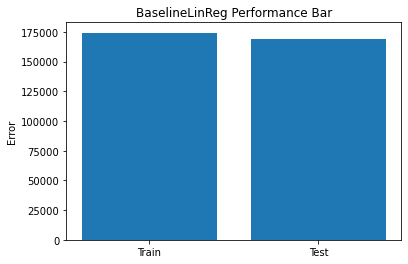

In [34]:
plt.bar(['Train', 'Test'], [train_score, test_score])
plt.ylabel('Error')
plt.title('BaselineLinReg Performance Bar');

It helps some, so we will use!